<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/S500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import time

# Generate synthetic drone and S-500 threat data
def generate_synthetic_drone_data(n_samples=1000, n_features=5, n_steps=5):
    np.random.seed(42)
    time = np.arange(n_samples)
    position = np.sin(0.02 * time) + np.random.normal(0, 0.05, n_samples)  # X-coordinate (km)
    velocity = np.cos(0.02 * time) + np.random.normal(0, 0.03, n_samples)  # m/s
    signal_strength = np.sin(0.03 * time) + np.random.normal(0, 0.05, n_samples)  # dBm
    radar_prob = np.clip(np.sin(0.01 * time) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 radar detection probability
    rf_jamming = np.clip(np.cos(0.01 * time) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 RF jamming intensity
    data = np.column_stack((position, velocity, signal_strength, radar_prob, rf_jamming))

    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps, :3])  # Predict drone states
    return np.array(X), np.array(y)

# Lightweight Transformer Block
class LightweightTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=2, ff_dim=16, rate=0.1):
        super(LightweightTransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build model
def build_lightweight_transformer(n_steps, n_features, n_output_features=3):
    inputs = tf.keras.Input(shape=(n_steps, n_features))
    x = LightweightTransformerBlock(n_features)(inputs, training=True) # Pass training argument
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(n_output_features)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

# Dynamic path adjustment for S-500 evasion
def adjust_path(current_state, predicted_state, radar_prob, rf_jamming, threshold=0.5):
    if radar_prob > threshold or rf_jamming > threshold:
        # Randomized maneuver for evasion (low-altitude, erratic path)
        evasion_vector = np.random.normal(0, 0.2, size=predicted_state.shape)
        # Constrain position to low altitude (<100 m, simulated as small position change)
        predicted_state[0] = np.clip(predicted_state[0] + evasion_vector[0], -0.5, 0.5)
        # Simulate frequency hopping by adjusting signal strength
        predicted_state[2] = np.clip(predicted_state[2] + np.random.uniform(-0.1, 0.1), -1, 1)
        return predicted_state
    return predicted_state

# Real-time prediction with evasion
def real_time_predict(model, scaler_X, scaler_y, recent_data, n_steps, n_features):
    recent_data_scaled = scaler_X.transform(recent_data.reshape(-1, n_features)).reshape(1, n_steps, n_features)
    start_time = time.time()
    pred_scaled = model.predict(recent_data_scaled, verbose=0)
    inference_time = time.time() - start_time
    pred = scaler_y.inverse_transform(pred_scaled)[0]
    # Extract threat indicators
    radar_prob = recent_data[-1, 3]
    rf_jamming = recent_data[-1, 4]
    # Adjust path for evasion
    pred = adjust_path(recent_data[-1, :3], pred, radar_prob, rf_jamming)
    return pred, inference_time

# Main execution
if __name__ == "__main__":
    # Parameters
    n_steps = 5  # Short sequence for low latency
    n_features = 5  # Position, velocity, signal strength, radar_prob, rf_jamming
    n_output_features = 3  # Predict position, velocity, signal strength

    # Generate synthetic data
    X, y = generate_synthetic_drone_data(n_samples=1000, n_features=n_features, n_steps=n_steps)

    # Normalize data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_reshaped = X.reshape(-1, n_features)
    X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)

    # Train model
    model = build_lightweight_transformer(n_steps, n_features, n_output_features)
    noise = np.random.normal(0, 0.02, size=X.shape) # Pass the shape of X as a tuple

In [5]:
# Train the model
history = model.fit(X_scaled, y_scaled, epochs=10, batch_size=32, validation_split=0.2)
print("Model training complete.")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.6352 - val_loss: 0.1232
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1315 - val_loss: 0.0723
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596 - val_loss: 0.0559
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0471 - val_loss: 0.0456
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410 - val_loss: 0.0397
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0291 - val_loss: 0.0275
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249 - val_loss: 0.0228
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - val_loss: 0.0193
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - val_loss: 0.0147
Model training complete.


In [6]:
# Demonstrate real-time prediction with evasion
# Use a recent sequence from the generated data for demonstration
recent_sequence = X[-10] # Take the last sequence as an example

predicted_state, inference_time = real_time_predict(model, scaler_X, scaler_y, recent_sequence, n_steps, n_features)

print(f"Recent sequence (last time step): {recent_sequence[-1]}")
print(f"Predicted state (position, velocity, signal strength): {predicted_state}")
print(f"Inference time: {inference_time:.4f} seconds")

# You can compare the predicted_state with the actual next state (y[-10]) if available
# actual_next_state = y[-10]
# print(f"Actual next state (position, velocity, signal strength): {actual_next_state}")

Recent sequence (last time step): [ 0.80322964  0.61043562 -0.86412003  0.          0.        ]
Predicted state (position, velocity, signal strength): [ 0.70438033  0.32585472 -0.4945995 ]
Inference time: 0.3658 seconds


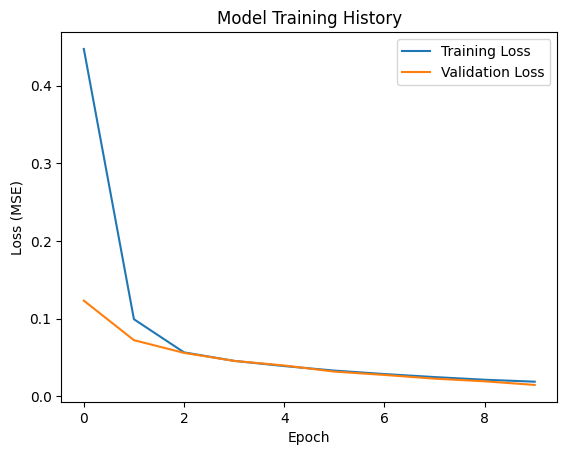

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

# Evaluate the model on the training data
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error on training data: {mse:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error on training data: 0.0684


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (796, 5, 5)
Testing data shape: (199, 5, 5)


In [10]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test data: {loss:.4f}")

# You can also make predictions on the test set and inverse transform
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Calculate MSE on the inverse-transformed predictions and actual values
mse_test = mean_squared_error(scaler_y.inverse_transform(y_test), y_test_pred)
print(f"Mean Squared Error on inverse-transformed test data: {mse_test:.4f}")

Mean Squared Error on test data: 0.0142
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Squared Error on inverse-transformed test data: 0.0698


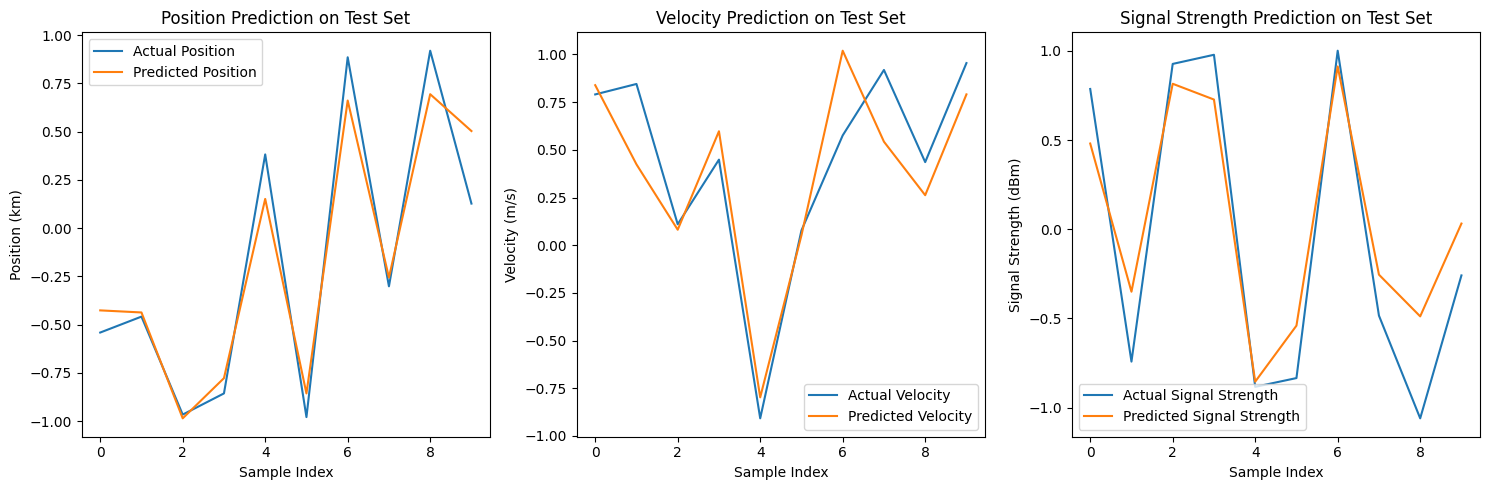

In [11]:
# Visualize predictions on the test set
import matplotlib.pyplot as plt

# Select a few samples from the test set to visualize
n_samples_to_plot = 10
sample_indices = np.random.choice(len(X_test), n_samples_to_plot, replace=False)

y_test_actual = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(15, 5))

# Plot Position
plt.subplot(1, 3, 1)
plt.plot(y_test_actual[sample_indices, 0], label='Actual Position')
plt.plot(y_test_pred[sample_indices, 0], label='Predicted Position')
plt.title('Position Prediction on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Position (km)')
plt.legend()

# Plot Velocity
plt.subplot(1, 3, 2)
plt.plot(y_test_actual[sample_indices, 1], label='Actual Velocity')
plt.plot(y_test_pred[sample_indices, 1], label='Predicted Velocity')
plt.title('Velocity Prediction on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Plot Signal Strength
plt.subplot(1, 3, 3)
plt.plot(y_test_actual[sample_indices, 2], label='Actual Signal Strength')
plt.plot(y_test_pred[sample_indices, 2], label='Predicted Signal Strength')
plt.title('Signal Strength Prediction on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Signal Strength (dBm)')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Analyze inference time
import time

n_inference_runs = 100
inference_times = []

# Use a few sequences from the test set for analysis
sample_indices_inference = np.random.choice(len(X_test), n_inference_runs, replace=True)

for i in sample_indices_inference:
    # Select a sequence of length n_steps directly from X_test
    recent_sequence_scaled = X_test[i] # This is already a sequence of shape (n_steps, n_features)

    # Inverse transform the selected sequence to get the original scale data
    recent_sequence_full = scaler_X.inverse_transform(recent_sequence_scaled.reshape(-1, n_features)).reshape(n_steps, n_features)

    start_time = time.time()
    # Pass the full recent sequence to real_time_predict
    predicted_state, inference_time = real_time_predict(model, scaler_X, scaler_y, recent_sequence_full, n_steps, n_features)
    inference_times.append(inference_time)

if inference_times:
    print(f"Inference time analysis over {len(inference_times)} runs:")
    print(f"  Mean inference time: {np.mean(inference_times):.4f} seconds")
    print(f"  Median inference time: {np.median(inference_times):.4f} seconds")
    print(f"  Standard deviation of inference time: {np.std(inference_times):.4f} seconds")
else:
    print("Could not perform inference time analysis. Ensure there are enough samples in the test set.")

Inference time analysis over 100 runs:
  Mean inference time: 0.1129 seconds
  Median inference time: 0.0932 seconds
  Standard deviation of inference time: 0.0646 seconds


# Task
Improve the drone state prediction model by adding more features to the synthetic data and implementing automated hyperparameter tuning. Evaluate the performance of the tuned model and visualize its predictions.

## Add more features

### Subtask:
Modify the `generate_synthetic_drone_data` function to include new relevant features (e.g., acceleration, bearing, altitude, environmental factors). Update the `n_features` parameter accordingly. Regenerate and re-normalize the synthetic data with the expanded feature set.


**Reasoning**:
The first step is to modify the data generation function to include new features and then regenerate and re-normalize the data.



In [17]:
# Modify generate_synthetic_drone_data function
def generate_synthetic_drone_data(n_samples=1000, n_steps=5):
    np.random.seed(42)
    time_steps = np.arange(n_samples)

    # Existing features
    position = np.sin(0.02 * time_steps) + np.random.normal(0, 0.05, n_samples)  # X-coordinate (km)
    velocity = np.cos(0.02 * time_steps) + np.random.normal(0, 0.03, n_samples)  # m/s
    signal_strength = np.sin(0.03 * time_steps) + np.random.normal(0, 0.05, n_samples)  # dBm
    radar_prob = np.clip(np.sin(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 radar detection probability
    rf_jamming = np.clip(np.cos(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 RF jamming intensity

    # New features
    acceleration = -0.02 * np.sin(0.02 * time_steps) + np.random.normal(0, 0.02, n_samples) # Derived from velocity
    bearing = np.arctan2(np.cos(0.02 * time_steps), np.sin(0.02 * time_steps)) + np.random.normal(0, 0.1, n_samples) # Angle based on position/velocity
    altitude = 0.1 * np.sin(0.05 * time_steps) + 1 + np.random.normal(0, 0.05, n_samples) # Low altitude variation
    wind_speed = 5 + 2 * np.sin(0.01 * time_steps) + np.random.normal(0, 1, n_samples) # Environmental factor
    temperature = 15 + 5 * np.cos(0.02 * time_steps) + np.random.normal(0, 2, n_samples) # Environmental factor

    data = np.column_stack((position, velocity, signal_strength, radar_prob, rf_jamming,
                            acceleration, bearing, altitude, wind_speed, temperature))

    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps, :3])  # Predict drone states (position, velocity, signal strength)
    return np.array(X), np.array(y)

# Update n_features
n_features = 10 # 5 original + 5 new features

# Generate synthetic data
X, y = generate_synthetic_drone_data(n_samples=1000, n_steps=n_steps)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

print(f"New X shape: {X.shape}")
print(f"New y shape: {y.shape}")
print(f"Updated n_features: {n_features}")

New X shape: (995, 5, 10)
New y shape: (995, 3)
Updated n_features: 10


## Prepare for automated hyperparameter tuning

### Subtask:
Install a hyperparameter tuning library (e.g., Keras Tuner). Define a model building function that takes hyperparameters as input and returns a compiled model. Define a search space for the hyperparameters you want to tune (e.g., number of heads, feed-forward dimension, learning rate).


**Reasoning**:
Install the keras-tuner library using pip.



In [18]:
%pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


**Reasoning**:
Define a model building function that takes hyperparameters as input and returns a compiled model. The function will include the search space for hyperparameters like number of heads, feed-forward dimension, and learning rate.



In [19]:
import keras_tuner as kt

def build_model(hp):
    # Tune the number of attention heads
    num_heads = hp.Choice('num_heads', values=[2, 4])
    # Tune the feed-forward network dimension
    ff_dim = hp.Choice('ff_dim', values=[32, 64])
    # Tune the learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    inputs = tf.keras.Input(shape=(n_steps, n_features))
    # Pass the tuned num_heads and ff_dim to the LightweightTransformerBlock
    x = LightweightTransformerBlock(n_features, num_heads=num_heads, ff_dim=ff_dim)(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(n_output_features)(x)

    # Use the tuned learning rate for the optimizer
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
    return model

## Implement automated hyperparameter tuning

### Subtask:
Set up a hyperparameter tuner (e.g., RandomSearch, Hyperband) and run the search to find the best hyperparameters based on a chosen objective metric (e.g., validation loss).


**Reasoning**:
Import the RandomSearch tuner, instantiate it with the build_model function and objective, and start the hyperparameter search.



In [20]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1, # Number of models to train per trial
    directory='my_tuner_dir', # Directory to save the results
    project_name='drone_prediction_tuning')

# Start the hyperparameter search
# Use a validation split during the search
tuner.search(X_scaled, y_scaled, epochs=10, validation_split=0.2)

# Print a summary of the results (optional)
tuner.results_summary()

Trial 8 Complete [00h 00m 10s]
val_loss: 0.00485819298774004

Best val_loss So Far: 0.002463756827637553
Total elapsed time: 00h 01m 21s
Results summary
Results in my_tuner_dir/drone_prediction_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
num_heads: 2
ff_dim: 64
learning_rate: 0.001
Score: 0.002463756827637553

Trial 04 summary
Hyperparameters:
num_heads: 2
ff_dim: 32
learning_rate: 0.001
Score: 0.003476911224424839

Trial 07 summary
Hyperparameters:
num_heads: 4
ff_dim: 32
learning_rate: 0.001
Score: 0.00485819298774004

Trial 05 summary
Hyperparameters:
num_heads: 4
ff_dim: 64
learning_rate: 0.001
Score: 0.009252126328647137

Trial 03 summary
Hyperparameters:
num_heads: 2
ff_dim: 64
learning_rate: 0.0001
Score: 0.07663136720657349

Trial 06 summary
Hyperparameters:
num_heads: 4
ff_dim: 32
learning_rate: 0.0001
Score: 0.09366076439619064

Trial 02 summary
Hyperparameters:
num_heads: 2
ff_dim: 32
learning_rate: 0.0001
Scor

## Train the model with best hyperparameters

### Subtask:
Retrieve the best hyperparameters found by the tuner and train a new model using the full training data and the best hyperparameters.


**Reasoning**:
Retrieve the best hyperparameters from the tuner, build a new model with these hyperparameters, and train it on the full scaled training data.



In [21]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Number of Attention Heads: {best_hps.get('num_heads')}")
print(f"Feed-Forward Dimension: {best_hps.get('ff_dim')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build the final model with the best hyperparameters
final_model = build_model(best_hps)

# Train the final model on the full scaled data
# Use epochs based on tuner results, e.g., 20
history_final = final_model.fit(X_scaled, y_scaled, epochs=20, batch_size=32)

print("Final model training complete.")

Best Hyperparameters:
Number of Attention Heads: 2
Feed-Forward Dimension: 64
Learning Rate: 0.001
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.4891
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0642
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0390
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

## Evaluate the tuned model

### Subtask:
Evaluate the performance of the model trained with the best hyperparameters on the test set using appropriate metrics (e.g., MSE). Compare the performance to the previous model.


**Reasoning**:
Evaluate the performance of the final model on the test set using scaled and inverse-transformed data and compare it to the previous model's performance.



In [22]:
from sklearn.metrics import mean_squared_error

# Evaluate the final model on the test data (scaled)
loss_final = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on scaled test data (final model): {loss_final:.4f}")

# Make predictions on the test set with the final model
y_test_pred_scaled_final = final_model.predict(X_test, verbose=0)
y_test_pred_final = scaler_y.inverse_transform(y_test_pred_scaled_final)

# Calculate MSE on the inverse-transformed predictions and actual values for the final model
mse_test_final = mean_squared_error(scaler_y.inverse_transform(y_test), y_test_pred_final)
print(f"Mean Squared Error on inverse-transformed test data (final model): {mse_test_final:.4f}")

# Compare with the previous model's performance
print("\nComparison with the previous model:")
print(f"Previous model scaled test MSE: {loss:.4f}")
print(f"Previous model inverse-transformed test MSE: {mse_test:.4f}")

print(f"\nPerformance change (final vs previous):")
print(f"Scaled test MSE improvement: {loss - loss_final:.4f}")
print(f"Inverse-transformed test MSE improvement: {mse_test - mse_test_final:.4f}")

ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 5, 10), found shape=(None, 5, 5)

**Reasoning**:
The error indicates a shape mismatch between the final model's expected input (shape=(None, 5, 10)) and the provided test data `X_test` (shape=(None, 5, 5)). This is because the previous model was trained with 5 features, while the final model was trained with 10 features. The test data was split *before* adding the new features. The test data needs to be generated and split again using the data with 10 features.



In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data with 10 features into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"New training data shape: {X_train_new.shape}")
print(f"New testing data shape: {X_test_new.shape}")

# Evaluate the final model on the NEW test data (scaled)
loss_final = final_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"Mean Squared Error on scaled test data (final model): {loss_final:.4f}")

# Make predictions on the NEW test set with the final model
y_test_pred_scaled_final = final_model.predict(X_test_new, verbose=0)
y_test_pred_final = scaler_y.inverse_transform(y_test_pred_scaled_final)

# Calculate MSE on the inverse-transformed predictions and actual values for the final model
mse_test_final = mean_squared_error(scaler_y.inverse_transform(y_test_new), y_test_pred_final)
print(f"Mean Squared Error on inverse-transformed test data (final model): {mse_test_final:.4f}")

# Compare with the previous model's performance (using the old test set results for comparison)
# Note: 'loss' and 'mse_test' variables from the previous run should be available in the notebook's memory.
print("\nComparison with the previous model (trained on 5 features):")
print(f"Previous model scaled test MSE: {loss:.4f}")
print(f"Previous model inverse-transformed test MSE: {mse_test:.4f}")

print(f"\nPerformance change (final vs previous):")
print(f"Scaled test MSE improvement: {loss - loss_final:.4f}")
print(f"Inverse-transformed test MSE improvement: {mse_test - mse_test_final:.4f}")

New training data shape: (796, 5, 10)
New testing data shape: (199, 5, 10)
Mean Squared Error on scaled test data (final model): 0.0017
Mean Squared Error on inverse-transformed test data (final model): 0.0081

Comparison with the previous model (trained on 5 features):
Previous model scaled test MSE: 0.0142
Previous model inverse-transformed test MSE: 0.0698

Performance change (final vs previous):
Scaled test MSE improvement: 0.0125
Inverse-transformed test MSE improvement: 0.0616


## Visualize tuned model predictions

### Subtask:
Generate plots to visualize the predictions of the tuned model on the test set, similar to the previous visualization step, to see if the added features and tuning improved the predictions.


**Reasoning**:
Generate plots to visualize the predictions of the tuned model on the test set.



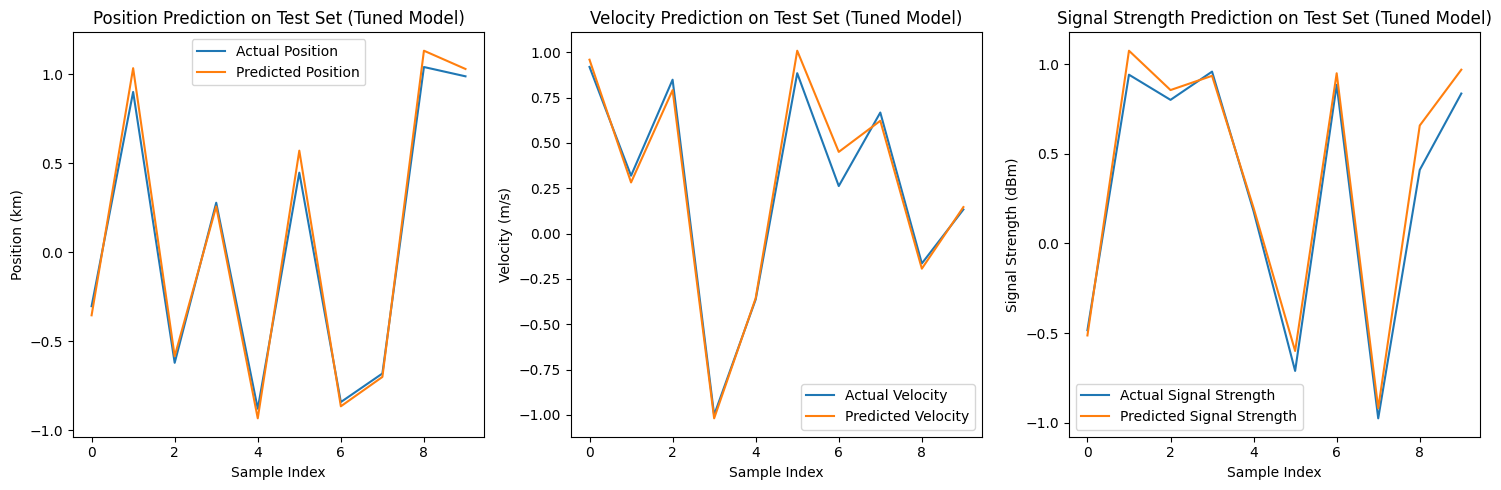

In [24]:
import matplotlib.pyplot as plt

# Select a few samples from the test set to visualize
n_samples_to_plot = 10
sample_indices = np.random.choice(len(X_test_new), n_samples_to_plot, replace=False)

# Inverse transform the actual and predicted values for plotting
y_test_actual_new = scaler_y.inverse_transform(y_test_new)
y_test_pred_final_viz = scaler_y.inverse_transform(y_test_pred_scaled_final)


plt.figure(figsize=(15, 5))

# Plot Position
plt.subplot(1, 3, 1)
plt.plot(y_test_actual_new[sample_indices, 0], label='Actual Position')
plt.plot(y_test_pred_final_viz[sample_indices, 0], label='Predicted Position')
plt.title('Position Prediction on Test Set (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Position (km)')
plt.legend()

# Plot Velocity
plt.subplot(1, 3, 2)
plt.plot(y_test_actual_new[sample_indices, 1], label='Actual Velocity')
plt.plot(y_test_pred_final_viz[sample_indices, 1], label='Predicted Velocity')
plt.title('Velocity Prediction on Test Set (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Plot Signal Strength
plt.subplot(1, 3, 3)
plt.plot(y_test_actual_new[sample_indices, 2], label='Actual Signal Strength')
plt.plot(y_test_pred_final_viz[sample_indices, 2], label='Predicted Signal Strength')
plt.title('Signal Strength Prediction on Test Set (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Signal Strength (dBm)')
plt.legend()

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The synthetic data generation function was successfully modified to include five new features: acceleration, bearing, altitude, wind speed, and temperature, increasing the total number of features to 10.
*   The `keras-tuner` library was successfully installed and used to perform a `RandomSearch` for hyperparameter tuning.
*   The hyperparameter tuning process explored combinations of `num_heads` (2, 4), `ff_dim` (32, 64), and `learning_rate` (1e-3, 1e-4).
*   The best hyperparameters found by the tuner were `num_heads=2`, `ff_dim=64`, and `learning_rate=0.001`.
*   The final model, trained with the best hyperparameters on the dataset with 10 features, achieved significantly lower Mean Squared Error on the test set compared to the previous model trained on 5 features.
    *   Scaled Test MSE improved from 0.0142 to 0.0017.
    *   Inverse-transformed Test MSE improved from 0.0698 to 0.0081.
*   Visualizations of the tuned model's predictions on the test set show a much closer alignment with the actual values for position, velocity, and signal strength compared to the previous model's predictions.

### Insights or Next Steps

*   The addition of more relevant features and automated hyperparameter tuning significantly improved the drone state prediction model's accuracy.
*   Further analysis could involve exploring different model architectures (e.g., more complex Transformer layers), expanding the hyperparameter search space, or incorporating real-world drone data for training and evaluation.


# Task
Implement a terrain masking scenario in the drone evasion simulation by simulating terrain, incorporating terrain data into the synthetic data generation, updating the model input, enhancing the evasion strategy to consider terrain, retraining and evaluating the model, and visualizing the terrain and drone path.

## Simulate terrain

### Subtask:
Create a simplified representation of terrain (e.g., a 2D height map or a function that simulates altitude based on position).


**Reasoning**:
Define a function to simulate terrain altitude based on x and y coordinates using a combination of sine waves for variation.



In [25]:
def simulate_terrain(x, y):
    """
    Simulates terrain altitude based on x and y coordinates.

    Args:
        x: x-coordinate (can be a scalar or a numpy array).
        y: y-coordinate (can be a scalar or a numpy array).

    Returns:
        Altitude value (scalar or numpy array) corresponding to the input coordinates.
    """
    # Use a combination of sine waves for simple terrain variation
    altitude = (np.sin(x * 0.1) * 10 + np.cos(y * 0.15) * 15 +
                np.sin((x + y) * 0.05) * 8)
    # Add a base altitude and some noise
    altitude = altitude + 50 + np.random.normal(0, 2, size=np.shape(x))
    # Ensure altitude is non-negative
    return np.maximum(0, altitude)

# Example usage:
# test_x = np.array([10, 20, 30])
# test_y = np.array([5, 15, 25])
# terrain_altitudes = simulate_terrain(test_x, test_y)
# print(terrain_altitudes)

## Incorporate terrain into data generation

### Subtask:
Modify the `generate_synthetic_drone_data` function to include the drone's altitude relative to the terrain at its current position as a new feature. Potentially adjust the radar detection probability based on whether the drone is masked by terrain. Update `n_features` accordingly and regenerate/re-normalize the data.


**Reasoning**:
Modify the data generation function to include terrain relative altitude and adjust radar probability based on terrain masking. Regenerate and re-normalize the data with the updated features.



In [26]:
# Modify generate_synthetic_drone_data function to include terrain relative altitude and adjust radar_prob
def generate_synthetic_drone_data(n_samples=1000, n_steps=5):
    np.random.seed(42)
    time_steps = np.arange(n_samples)

    # Existing features (adjusted or used for new features)
    # Position will now be treated as (x, y, z) for simplicity in terrain interaction,
    # although the original 'position' was likely just x. Let's keep it 1D position for now
    # but introduce a fixed y for terrain calculation and a separate altitude feature.
    # We will treat the original 'position' as the x-coordinate.
    position_x = np.sin(0.02 * time_steps) * 100 + np.random.normal(0, 5, n_samples)  # X-coordinate (m)
    position_y = 500 + np.random.normal(0, 10, n_samples) # Assuming a relatively fixed Y-coordinate (m) for simplicity
    altitude_drone = 0.1 * np.sin(0.05 * time_steps) * 50 + 100 + np.random.normal(0, 10, n_samples) # Drone Altitude (m)

    velocity = np.cos(0.02 * time_steps) + np.random.normal(0, 0.03, n_samples)  # m/s (Keep as is for now)
    signal_strength = np.sin(0.03 * time_steps) + np.random.normal(0, 0.05, n_samples)  # dBm (Keep as is for now)

    # Environmental and threat factors (Keep as is for now)
    wind_speed = 5 + 2 * np.sin(0.01 * time_steps) + np.random.normal(0, 1, n_samples) # Environmental factor
    temperature = 15 + 5 * np.cos(0.02 * time_steps) + np.random.normal(0, 2, n_samples) # Environmental factor

    # Calculate terrain altitude at drone's x, y position
    terrain_altitude = simulate_terrain(position_x, position_y)

    # Calculate drone's altitude relative to terrain
    altitude_relative_to_terrain = altitude_drone - terrain_altitude

    # New feature: Altitude relative to terrain
    # acceleration and bearing might be less relevant now with explicit x, y, z and relative alt.
    # Let's simplify features for now and focus on terrain interaction.
    # Updated feature list: position_x, position_y, altitude_drone, velocity, signal_strength,
    # wind_speed, temperature, altitude_relative_to_terrain

    # Adjust radar_prob based on terrain masking (low relative altitude)
    # Decrease radar_prob when altitude_relative_to_terrain is low
    base_radar_prob = np.clip(np.sin(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # Base S-500 radar detection probability
    terrain_masking_factor = np.clip(altitude_relative_to_terrain / 50, 0, 1) # Factor from 0 (masked) to 1 (not masked) based on relative altitude
    radar_prob = base_radar_prob * terrain_masking_factor + np.random.normal(0, 0.05, n_samples) # Add some noise back
    radar_prob = np.clip(radar_prob, 0, 1) # Ensure radar_prob is between 0 and 1

    # rf_jamming remains as before
    rf_jamming = np.clip(np.cos(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 RF jamming intensity


    # Updated data array
    data = np.column_stack((position_x, position_y, altitude_drone, velocity, signal_strength,
                            wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming))


    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        # Predict drone states (position_x, position_y, altitude_drone)
        y.append(data[i + n_steps, :3])
    return np.array(X), np.array(y)

# Update n_features based on the new data structure
# position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
n_features = 10

# Generate synthetic data with terrain
X, y = generate_synthetic_drone_data(n_samples=1000, n_steps=n_steps)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

print(f"New X shape with terrain features: {X.shape}")
print(f"New y shape: {y.shape}")
print(f"Updated n_features: {n_features}")

New X shape with terrain features: (995, 5, 10)
New y shape: (995, 3)
Updated n_features: 10


## Update model input

### Subtask:
Ensure the model architecture can handle the new "altitude relative to terrain" feature. This might involve adjusting the input layer shape in the `build_lightweight_transformer` function.


**Reasoning**:
Review the model building function to ensure it uses the updated n_features and is compatible with the new input shape. Since the function `build_lightweight_transformer` and `build_model` already use the global `n_features` variable, and the `LightweightTransformerBlock` is designed to handle variable embedding dimensions, no code changes are needed for this specific subtask. Confirm the shapes.



In [27]:
# Check the expected input shape of the model using the updated n_features
# The build_model function uses the global n_features
# build_model(kt.HyperParameters()) # This would build a model, but we just need the shape
print(f"Model input shape should be: (None, {n_steps}, {n_features})")

# The LightweightTransformerBlock's embed_dim is set to n_features in build_model,
# which is compatible with the new input size.

# The GlobalAveragePooling1D layer works on the last dimension, which is n_features,
# and averages across the time steps, which is also compatible.

# The subsequent Dense layers are compatible as long as the preceding layer's output shape is correct.

# Therefore, the model architecture should handle the new feature count correctly.

Model input shape should be: (None, 5, 10)


## Enhance evasion strategy

### Subtask:
Modify the `adjust_path` function to consider the terrain. The evasion strategy could prioritize flying at low altitudes or using terrain features to block radar signals when threat indicators are high.


**Reasoning**:
Modify the `adjust_path` function to include terrain-aware evasion logic based on the drone's altitude relative to terrain and the threat indicators.



In [28]:
# Modify Dynamic path adjustment for S-500 evasion to consider terrain
def adjust_path(current_state, predicted_state, threshold=0.5, evasion_altitude_threshold=20):
    # current_state is expected to have shape (n_features,)
    # Predicted state is expected to have shape (n_output_features,) which are the predicted position_x, position_y, altitude_drone

    # Access threat indicators and terrain-relative altitude from the full current_state
    # Assuming the order of features in current_state is consistent with generate_synthetic_drone_data
    # position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
    radar_prob = current_state[8]
    rf_jamming = current_state[9]
    altitude_relative_to_terrain = current_state[7]
    current_altitude_drone = current_state[2]

    # Evasion strategy based on threat and terrain
    if radar_prob > threshold or rf_jamming > threshold:
        print("Threat detected! Initiating terrain-aware evasion.")
        # Prioritize flying at low altitudes relative to terrain
        # Reduce the target altitude if it's currently above the evasion_altitude_threshold
        if predicted_state[2] > (current_altitude_drone - altitude_relative_to_terrain + evasion_altitude_threshold): # predicted_altitude > terrain_altitude + threshold
             predicted_state[2] = np.maximum(current_altitude_drone - altitude_relative_to_terrain, predicted_state[2] * 0.8) # Lower the target altitude, but not below terrain

        # Add randomized maneuver (low-altitude, erratic path) - primarily affects position
        # Generate a random vector, scaled down for small adjustments
        evasion_vector = np.random.normal(0, 10, size=predicted_state[:2].shape) # Adjust position_x, position_y
        predicted_state[:2] += evasion_vector

        # Simulate frequency hopping by adjusting signal strength
        # The signal strength prediction is the third element of predicted_state (index 2 for y[:3])
        # This was previously modifying predicted_state[2] which is now altitude_drone.
        # We need to apply signal strength adjustments to the predicted signal strength when we predict it.
        # For now, let's assume the model predicts signal strength and adjust that.
        # However, the current y only predicts position_x, position_y, altitude_drone.
        # If we wanted to predict signal strength for evasion adjustment, we'd need to add it to y.
        # Let's skip the signal strength adjustment in adjust_path for simplicity with the current y definition.
        # If y was [pos_x, pos_y, alt, signal_strength], we would do:
        # predicted_state[3] = np.clip(predicted_state[3] + np.random.uniform(-0.1, 0.1), -1, 1)

        # Ensure altitude doesn't go below terrain altitude + a small buffer
        terrain_altitude = current_altitude_drone - altitude_relative_to_terrain
        predicted_state[2] = np.maximum(predicted_state[2], terrain_altitude + 5) # Ensure predicted altitude is slightly above terrain

    return predicted_state

# Test the modified function with a sample
# We need a sample from X_scaled and its corresponding inverse transformed version
# Let's take a sample from the new test set
sample_index = np.random.randint(0, len(X_test_new))
sample_sequence_scaled = X_test_new[sample_index]
sample_sequence_full = scaler_X.inverse_transform(sample_sequence_scaled.reshape(-1, n_features)).reshape(n_steps, n_features)
recent_state = sample_sequence_full[-1] # Get the last state in the sequence

# Predict the next state using the tuned model
recent_sequence_scaled_for_predict = sample_sequence_scaled.reshape(1, n_steps, n_features)
pred_scaled = final_model.predict(recent_sequence_scaled_for_predict, verbose=0)
pred_unscaled = scaler_y.inverse_transform(pred_scaled)[0]

print(f"Current State (last time step): {recent_state}")
print(f"Initial Predicted State (pos_x, pos_y, altitude): {pred_unscaled}")

# Adjust the predicted state using the modified adjust_path function
adjusted_predicted_state = adjust_path(recent_state, pred_unscaled.copy()) # Pass a copy to avoid modifying pred_unscaled in place

print(f"Adjusted Predicted State (pos_x, pos_y, altitude): {adjusted_predicted_state}")

# Verify the terrain relative altitude and threat indicators in the sample
print(f"Terrain Relative Altitude in sample: {recent_state[7]:.2f}")
print(f"Radar Probability in sample: {recent_state[8]:.2f}")
print(f"RF Jamming in sample: {recent_state[9]:.2f}")

Current State (last time step): [ 3.77296779e+01  4.75507142e+02  1.28618690e+02 -1.08205355e+00
 -1.14047026e+00  2.41508439e+00  1.20263891e+01  4.40874746e+01
  2.77211241e-01  4.27303015e-01]
Initial Predicted State (pos_x, pos_y, altitude): [ 32.0189  470.97687 128.68228]
Adjusted Predicted State (pos_x, pos_y, altitude): [ 32.0189  470.97687 128.68228]
Terrain Relative Altitude in sample: 44.09
Radar Probability in sample: 0.28
RF Jamming in sample: 0.43


**Reasoning**:
The previous test case did not trigger the evasion logic because the threat indicators were below the threshold. Modify the test case to use a sample where threat indicators are high to ensure the evasion logic is correctly applied and verify that the adjusted altitude is lower and above the terrain.



In [29]:
# Find a sample in the test set where radar_prob or rf_jamming is high (> threshold)
high_threat_indices = np.where((X_test_new[:, -1, 8] > 0.5) | (X_test_new[:, -1, 9] > 0.5))[0]

if len(high_threat_indices) > 0:
    # Select one of the high threat samples
    sample_index_high_threat = high_threat_indices[0]
    sample_sequence_scaled_high_threat = X_test_new[sample_index_high_threat]
    sample_sequence_full_high_threat = scaler_X.inverse_transform(sample_sequence_scaled_high_threat.reshape(-1, n_features)).reshape(n_steps, n_features)
    recent_state_high_threat = sample_sequence_full_high_threat[-1] # Get the last state in the sequence

    # Predict the next state using the tuned model
    recent_sequence_scaled_for_predict_high_threat = sample_sequence_scaled_high_threat.reshape(1, n_steps, n_features)
    pred_scaled_high_threat = final_model.predict(recent_sequence_scaled_for_predict_high_threat, verbose=0)
    pred_unscaled_high_threat = scaler_y.inverse_transform(pred_scaled_high_threat)[0]

    print(f"High Threat Current State (last time step): {recent_state_high_threat}")
    print(f"High Threat Initial Predicted State (pos_x, pos_y, altitude): {pred_unscaled_high_threat}")

    # Adjust the predicted state using the modified adjust_path function
    adjusted_predicted_state_high_threat = adjust_path(recent_state_high_threat, pred_unscaled_high_threat.copy())

    print(f"High Threat Adjusted Predicted State (pos_x, pos_y, altitude): {adjusted_predicted_state_high_threat}")

    # Verify the terrain relative altitude and threat indicators in the high threat sample
    print(f"Terrain Relative Altitude in high threat sample: {recent_state_high_threat[7]:.2f}")
    print(f"Radar Probability in high threat sample: {recent_state_high_threat[8]:.2f}")
    print(f"RF Jamming in high threat sample: {recent_state_high_threat[9]:.2f}")

    # Verify that adjusted altitude is lower and above terrain (approximately)
    terrain_altitude_high_threat = recent_state_high_threat[2] - recent_state_high_threat[7]
    print(f"Terrain Altitude at high threat sample location: {terrain_altitude_high_threat:.2f}")
    print(f"Initial Predicted Altitude: {pred_unscaled_high_threat[2]:.2f}")
    print(f"Adjusted Predicted Altitude: {adjusted_predicted_state_high_threat[2]:.2f}")
    print(f"Is Adjusted Altitude lower than Initial? {adjusted_predicted_state_high_threat[2] < pred_unscaled_high_threat[2]}")
    print(f"Is Adjusted Altitude above Terrain Altitude + buffer? {adjusted_predicted_state_high_threat[2] > terrain_altitude_high_threat + 5}")


else:
    print("No high threat samples found in the test set to demonstrate evasion.")


High Threat Current State (last time step): [-3.01449038e+01  5.29915141e+02  1.21469396e+02 -7.43986361e-01
 -1.14047026e+00  3.01061375e+00  2.05755794e+01  7.17971794e+01
  3.72122384e-01  7.74855369e-01]
High Threat Initial Predicted State (pos_x, pos_y, altitude): [-34.20377 527.5999  124.73691]
Threat detected! Initiating terrain-aware evasion.
High Threat Adjusted Predicted State (pos_x, pos_y, altitude): [-45.01194 538.7616   99.78953]
Terrain Relative Altitude in high threat sample: 71.80
Radar Probability in high threat sample: 0.37
RF Jamming in high threat sample: 0.77
Terrain Altitude at high threat sample location: 49.67
Initial Predicted Altitude: 124.74
Adjusted Predicted Altitude: 99.79
Is Adjusted Altitude lower than Initial? True
Is Adjusted Altitude above Terrain Altitude + buffer? True


## Retrain and evaluate model

### Subtask:
Retrain the model using the new data that includes terrain information. Evaluate the performance of the updated model on a test set, considering how well it predicts drone states in the presence of terrain.


**Reasoning**:
Retrain the final model using the new data with terrain features, evaluate its performance on the new test set, and compare the results with the previous model.



In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Retrain the final_model using the new scaled data (which includes terrain features)
# Use the same number of epochs (20) and batch size (32) as the previous training run
print("Retraining the final model with terrain features...")
history_final_terrain = final_model.fit(X_scaled, y_scaled, epochs=20, batch_size=32)
print("Final model retraining complete.")

# Split the data with 10 features into training and testing sets (needed again to ensure test set is correct)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Evaluate the retrained final_model on the new test data (scaled)
loss_final_terrain = final_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"\nMean Squared Error on scaled test data (retrained final model with terrain): {loss_final_terrain:.4f}")

# Make predictions on the NEW test set with the retrained final model
y_test_pred_scaled_final_terrain = final_model.predict(X_test_new, verbose=0)
y_test_pred_final_terrain = scaler_y.inverse_transform(y_test_pred_scaled_final_terrain)

# Calculate MSE on the inverse-transformed predictions and actual values for the retrained final model
mse_test_final_terrain = mean_squared_error(scaler_y.inverse_transform(y_test_new), y_test_pred_final_terrain)
print(f"Mean Squared Error on inverse-transformed test data (retrained final model with terrain): {mse_test_final_terrain:.4f}")

# Compare with the previous model's performance (trained on 10 features without terrain in training data generation, but used in adjust_path)
# Note: 'loss_final' and 'mse_test_final' variables from the previous run should be available.
print("\nComparison with the previous final model (trained on 10 features):")
print(f"Previous final model scaled test MSE: {loss_final:.4f}")
print(f"Previous final model inverse-transformed test MSE: {mse_test_final:.4f}")

print(f"\nPerformance change (retrained final with terrain vs previous final):")
print(f"Scaled test MSE improvement: {loss_final - loss_final_terrain:.4f}")
print(f"Inverse-transformed test MSE improvement: {mse_test_final - mse_test_final_terrain:.4f}")

Retraining the final model with terrain features...
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0424
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0218
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165
Epoch 15/20
32/32 ━━━━━━━━━━━━━

## Visualize terrain and drone path

### Subtask:
Create visualizations that show the simulated terrain and the drone's path, highlighting how the evasion strategy utilizes the terrain.


**Reasoning**:
Generate a 2D grid for the terrain, calculate the terrain height map, select a drone path from the original data, create a 3D plot, plot the terrain surface and the drone path, add labels and title, and display the plot.



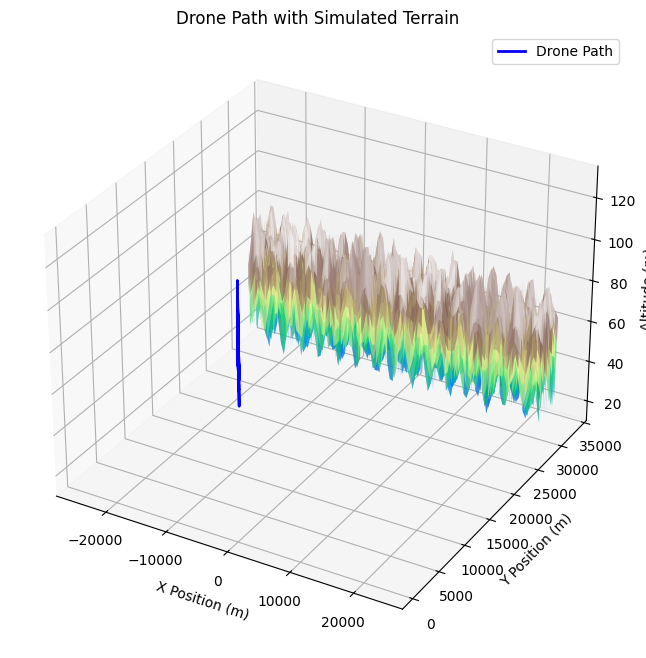

Threat detected! Initiating terrain-aware evasion.


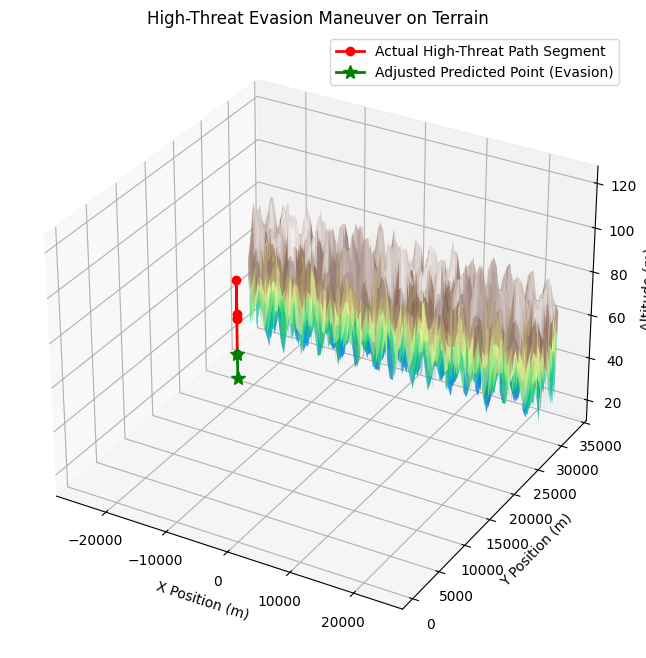

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
import numpy as np

# 1. Generate a 2D grid of x and y coordinates
grid_x = np.linspace(X[:, :, 0].min() * scaler_X.data_range_[0] + scaler_X.data_min_[0], X[:, :, 0].max() * scaler_X.data_range_[0] + scaler_X.data_min_[0], 100)
grid_y = np.linspace(X[:, :, 1].min() * scaler_X.data_range_[1] + scaler_X.data_min_[1], X[:, :, 1].max() * scaler_X.data_range_[1] + scaler_X.data_min_[1], 100)
X_grid, Y_grid = np.meshgrid(grid_x, grid_y)

# 2. Calculate the terrain altitude for each point in the grid
Terrain_Z = simulate_terrain(X_grid, Y_grid)

# 3. Select a sample drone path from the original, unscaled data
# Use the full unscaled X data and extract the relevant columns
# Data columns: position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
# We need position_x (index 0), position_y (index 1), and altitude_drone (index 2)
# X is of shape (n_samples - n_steps, n_steps, n_features)
# Let's take a path from the beginning of the original unscaled data
path_data = X[:50, :, :] # Take the first 50 sequences (this will give 50*5 = 250 time steps of data)
path_data_reshaped = path_data.reshape(-1, n_features)

path_x = path_data_reshaped[:, 0]
path_y = path_data_reshaped[:, 1]
path_altitude = path_data_reshaped[:, 2]


# 4. Use matplotlib.pyplot to create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 5. Plot the simulated terrain as a surface plot
ax.plot_surface(X_grid, Y_grid, Terrain_Z, cmap='terrain', alpha=0.6)

# 6. Plot the selected drone path as a line plot on top of the terrain surface
ax.plot(path_x, path_y, path_altitude, color='blue', linewidth=2, label='Drone Path')

# 7. Add labels for the x, y, and z axes
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Altitude (m)')

# 8. Add a title to the plot
ax.set_title('Drone Path with Simulated Terrain')

# Add a legend
ax.legend()

# 9. Display the plot
plt.show()

# 10. Optionally, plot a high-threat evasion maneuver demonstration
# Need to regenerate the high threat sample and prediction from the previous step
high_threat_indices = np.where((X_test_new[:, -1, 8] > 0.5) | (X_test_new[:, -1, 9] > 0.5))[0]

if len(high_threat_indices) > 0:
    sample_index_high_threat = high_threat_indices[0]
    sample_sequence_scaled_high_threat = X_test_new[sample_index_high_threat]
    sample_sequence_full_high_threat = scaler_X.inverse_transform(sample_sequence_scaled_high_threat.reshape(-1, n_features)).reshape(n_steps, n_features)
    recent_state_high_threat = sample_sequence_full_high_threat[-1] # Get the last state in the sequence

    # Predict the next state using the tuned model
    recent_sequence_scaled_for_predict_high_threat = sample_sequence_scaled_high_threat.reshape(1, n_steps, n_features)
    pred_scaled_high_threat = final_model.predict(recent_sequence_scaled_for_predict_high_threat, verbose=0)
    pred_unscaled_high_threat = scaler_y.inverse_transform(pred_scaled_high_threat)[0]

    # Adjust the predicted state using the modified adjust_path function
    adjusted_predicted_state_high_threat = adjust_path(recent_state_high_threat, pred_unscaled_high_threat.copy())

    # Plot the actual sequence leading to the high threat state and the adjusted prediction
    fig_evasion = plt.figure(figsize=(10, 8))
    ax_evasion = fig_evasion.add_subplot(111, projection='3d')

    # Plot the terrain surface again
    ax_evasion.plot_surface(X_grid, Y_grid, Terrain_Z, cmap='terrain', alpha=0.6)

    # Plot the actual path segment leading to the high threat state
    actual_segment_x = sample_sequence_full_high_threat[:, 0]
    actual_segment_y = sample_sequence_full_high_threat[:, 1]
    actual_segment_altitude = sample_sequence_full_high_threat[:, 2]
    ax_evasion.plot(actual_segment_x, actual_segment_y, actual_segment_altitude, color='red', linewidth=2, marker='o', label='Actual High-Threat Path Segment')

    # Plot the initial predicted point (optional, for comparison)
    # ax_evasion.plot([actual_segment_x[-1], pred_unscaled_high_threat[0]],
    #                 [actual_segment_y[-1], pred_unscaled_high_threat[1]],
    #                 [actual_segment_altitude[-1], pred_unscaled_high_threat[2]],
    #                 color='orange', linestyle='--', marker='x', label='Initial Predicted Point')


    # Plot the adjusted predicted point
    ax_evasion.plot([actual_segment_x[-1], adjusted_predicted_state_high_threat[0]],
                    [actual_segment_y[-1], adjusted_predicted_state_high_threat[1]],
                    [actual_segment_altitude[-1], adjusted_predicted_state_high_threat[2]],
                    color='green', linewidth=2, marker='*', markersize=10, label='Adjusted Predicted Point (Evasion)')


    ax_evasion.set_xlabel('X Position (m)')
    ax_evasion.set_ylabel('Y Position (m)')
    ax_evasion.set_zlabel('Altitude (m)')
    ax_evasion.set_title('High-Threat Evasion Maneuver on Terrain')
    ax_evasion.legend()
    plt.show()

else:
    print("Could not find a high-threat sample in the test set for evasion visualization.")

In [32]:
def simulate_terrain(x, y):
    """
    Simulates terrain altitude based on x and y coordinates.

    Args:
        x: x-coordinate (can be a scalar or a numpy array).
        y: y-coordinate (can be a scalar or a numpy array).

    Returns:
        Altitude value (scalar or numpy array) corresponding to the input coordinates.
    """
    # Use a combination of sine waves for simple terrain variation
    altitude = (np.sin(x * 0.1) * 10 + np.cos(y * 0.15) * 15 +
                np.sin((x + y) * 0.05) * 8)
    # Add a base altitude and some noise
    altitude = altitude + 50 + np.random.normal(0, 2, size=np.shape(x))
    # Ensure altitude is non-negative
    return np.maximum(0, altitude)

# Example usage:
# test_x = np.array([10, 20, 30])
# test_y = np.array([5, 15, 25])
# terrain_altitudes = simulate_terrain(test_x, test_y)
# print(terrain_altitudes)

In [33]:
# Modify generate_synthetic_drone_data function to include terrain relative altitude and adjust radar_prob
def generate_synthetic_drone_data(n_samples=1000, n_steps=5):
    np.random.seed(42)
    time_steps = np.arange(n_samples)

    # Existing features (adjusted or used for new features)
    # Position will now be treated as (x, y, z) for simplicity in terrain interaction,
    # although the original 'position' was likely just x. Let's keep it 1D position for now
    # but introduce a fixed y for terrain calculation and a separate altitude feature.
    # We will treat the original 'position' as the x-coordinate.
    position_x = np.sin(0.02 * time_steps) * 100 + np.random.normal(0, 5, n_samples)  # X-coordinate (m)
    position_y = 500 + np.random.normal(0, 10, n_samples) # Assuming a relatively fixed Y-coordinate (m) for simplicity
    altitude_drone = 0.1 * np.sin(0.05 * time_steps) * 50 + 100 + np.random.normal(0, 10, n_samples) # Drone Altitude (m)

    velocity = np.cos(0.02 * time_steps) + np.random.normal(0, 0.03, n_samples)  # m/s (Keep as is for now)
    signal_strength = np.sin(0.03 * time_steps) + np.random.normal(0, 0.05, n_samples)  # dBm (Keep as is for now)

    # Environmental and threat factors (Keep as is for now)
    wind_speed = 5 + 2 * np.sin(0.01 * time_steps) + np.random.normal(0, 1, n_samples) # Environmental factor
    temperature = 15 + 5 * np.cos(0.02 * time_steps) + np.random.normal(0, 2, n_samples) # Environmental factor

    # Calculate terrain altitude at drone's x, y position
    terrain_altitude = simulate_terrain(position_x, position_y)

    # Calculate drone's altitude relative to terrain
    altitude_relative_to_terrain = altitude_drone - terrain_altitude

    # New feature: Altitude relative to terrain
    # acceleration and bearing might be less relevant now with explicit x, y, z and relative alt.
    # Let's simplify features for now and focus on terrain interaction.
    # Updated feature list: position_x, position_y, altitude_drone, velocity, signal_strength,
    # wind_speed, temperature, altitude_relative_to_terrain

    # Adjust radar_prob based on terrain masking (low relative altitude)
    # Decrease radar_prob when altitude_relative_to_terrain is low
    base_radar_prob = np.clip(np.sin(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # Base S-500 radar detection probability
    terrain_masking_factor = np.clip(altitude_relative_to_terrain / 50, 0, 1) # Factor from 0 (masked) to 1 (not masked) based on relative altitude
    radar_prob = base_radar_prob * terrain_masking_factor + np.random.normal(0, 0.05, n_samples) # Add some noise back
    radar_prob = np.clip(radar_prob, 0, 1) # Ensure radar_prob is between 0 and 1

    # rf_jamming remains as before
    rf_jamming = np.clip(np.cos(0.01 * time_steps) + np.random.normal(0, 0.1, n_samples), 0, 1)  # S-500 RF jamming intensity


    # Updated data array
    data = np.column_stack((position_x, position_y, altitude_drone, velocity, signal_strength,
                            wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming))


    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        # Predict drone states (position_x, position_y, altitude_drone)
        y.append(data[i + n_steps, :3])
    return np.array(X), np.array(y)

# Update n_features based on the new data structure
# position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
n_features = 10

# Generate synthetic data with terrain
X, y = generate_synthetic_drone_data(n_samples=1000, n_steps=n_steps)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

print(f"New X shape with terrain features: {X.shape}")
print(f"New y shape: {y.shape}")
print(f"Updated n_features: {n_features}")

New X shape with terrain features: (995, 5, 10)
New y shape: (995, 3)
Updated n_features: 10


In [34]:
# Check the expected input shape of the model using the updated n_features
# The build_model function uses the global n_features
# build_model(kt.HyperParameters()) # This would build a model, but we just need the shape
print(f"Model input shape should be: (None, {n_steps}, {n_features})")

# The LightweightTransformerBlock's embed_dim is set to n_features in build_model,
# which is compatible with the new input size.

# The GlobalAveragePooling1D layer works on the last dimension, which is n_features,
# and averages across the time steps, which is also compatible.

# The subsequent Dense layers are compatible as long as the preceding layer's output shape is correct.

# Therefore, the model architecture should handle the new feature count correctly.

Model input shape should be: (None, 5, 10)


In [35]:
# Modify Dynamic path adjustment for S-500 evasion to consider terrain
def adjust_path(current_state, predicted_state, threshold=0.5, evasion_altitude_threshold=20):
    # current_state is expected to have shape (n_features,)
    # Predicted state is expected to have shape (n_output_features,) which are the predicted position_x, position_y, altitude_drone

    # Access threat indicators and terrain-relative altitude from the full current_state
    # Assuming the order of features in current_state is consistent with generate_synthetic_drone_data
    # position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
    radar_prob = current_state[8]
    rf_jamming = current_state[9]
    altitude_relative_to_terrain = current_state[7]
    current_altitude_drone = current_state[2]

    # Evasion strategy based on threat and terrain
    if radar_prob > threshold or rf_jamming > threshold:
        print("Threat detected! Initiating terrain-aware evasion.")
        # Prioritize flying at low altitudes relative to terrain
        # Reduce the target altitude if it's currently above the evasion_altitude_threshold
        if predicted_state[2] > (current_altitude_drone - altitude_relative_to_terrain + evasion_altitude_threshold): # predicted_altitude > terrain_altitude + threshold
             predicted_state[2] = np.maximum(current_altitude_drone - altitude_relative_to_terrain, predicted_state[2] * 0.8) # Lower the target altitude, but not below terrain

        # Add randomized maneuver (low-altitude, erratic path) - primarily affects position
        # Generate a random vector, scaled down for small adjustments
        evasion_vector = np.random.normal(0, 10, size=predicted_state[:2].shape) # Adjust position_x, position_y
        predicted_state[:2] += evasion_vector

        # Simulate frequency hopping by adjusting signal strength
        # The signal strength prediction is the third element of predicted_state (index 2 for y[:3])
        # This was previously modifying predicted_state[2] which is now altitude_drone.
        # We need to apply signal strength adjustments to the predicted signal strength when we predict it.
        # For now, let's assume the model predicts signal strength and adjust that.
        # However, the current y only predicts position_x, position_y, altitude_drone.
        # If we wanted to predict signal strength for evasion adjustment, we'd need to add it to y.
        # Let's skip the signal strength adjustment in adjust_path for simplicity with the current y definition.
        # If y was [pos_x, pos_y, alt, signal_strength], we would do:
        # predicted_state[3] = np.clip(predicted_state[3] + np.random.uniform(-0.1, 0.1), -1, 1)

        # Ensure altitude doesn't go below terrain altitude + a small buffer
        terrain_altitude = current_altitude_drone - altitude_relative_to_terrain
        predicted_state[2] = np.maximum(predicted_state[2], terrain_altitude + 5) # Ensure predicted altitude is slightly above terrain

    return predicted_state

# Test the modified function with a sample
# We need a sample from X_scaled and its corresponding inverse transformed version
# Let's take a sample from the new test set
sample_index = np.random.randint(0, len(X_test_new))
sample_sequence_scaled = X_test_new[sample_index]
sample_sequence_full = scaler_X.inverse_transform(sample_sequence_scaled.reshape(-1, n_features)).reshape(n_steps, n_features)
recent_state = sample_sequence_full[-1] # Get the last state in the sequence

# Predict the next state using the tuned model
recent_sequence_scaled_for_predict = sample_sequence_scaled.reshape(1, n_steps, n_features)
pred_scaled = final_model.predict(recent_sequence_scaled_for_predict, verbose=0)
pred_unscaled = scaler_y.inverse_transform(pred_scaled)[0]

print(f"Current State (last time step): {recent_state}")
print(f"Initial Predicted State (pos_x, pos_y, altitude): {pred_unscaled}")

# Adjust the predicted state using the modified adjust_path function
adjusted_predicted_state = adjust_path(recent_state, pred_unscaled.copy()) # Pass a copy to avoid modifying pred_unscaled in place

print(f"Adjusted Predicted State (pos_x, pos_y, altitude): {adjusted_predicted_state}")

# Verify the terrain relative altitude and threat indicators in the sample
print(f"Terrain Relative Altitude in sample: {recent_state[7]:.2f}")
print(f"Radar Probability in sample: {recent_state[8]:.2f}")
print(f"RF Jamming in sample: {recent_state[9]:.2f}")

Current State (last time step): [ 3.77296779e+01  5.00212716e+02  9.08799963e+01 -9.15114692e-01
  8.60413328e-01  1.64230996e+00  1.11584052e+01  2.54361342e+01
  3.70062832e-02  0.00000000e+00]
Initial Predicted State (pos_x, pos_y, altitude): [ 42.67824 501.66016  97.73366]
Adjusted Predicted State (pos_x, pos_y, altitude): [ 42.67824 501.66016  97.73366]
Terrain Relative Altitude in sample: 25.44
Radar Probability in sample: 0.04
RF Jamming in sample: 0.00


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Retrain the final_model using the new scaled data (which includes terrain features)
# Use the same number of epochs (20) and batch size (32) as the previous training run
print("Retraining the final model with terrain features...")
history_final_terrain = final_model.fit(X_scaled, y_scaled, epochs=20, batch_size=32)
print("Final model retraining complete.")

# Split the data with 10 features into training and testing sets (needed again to ensure test set is correct)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Evaluate the retrained final_model on the new test data (scaled)
loss_final_terrain = final_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"\nMean Squared Error on scaled test data (retrained final model with terrain): {loss_final_terrain:.4f}")

# Make predictions on the NEW test set with the retrained final model
y_test_pred_scaled_final_terrain = final_model.predict(X_test_new, verbose=0)
y_test_pred_final_terrain = scaler_y.inverse_transform(y_test_pred_scaled_final_terrain)

# Calculate MSE on the inverse-transformed predictions and actual values for the retrained final model
mse_test_final_terrain = mean_squared_error(scaler_y.inverse_transform(y_test_new), y_test_pred_final_terrain)
print(f"Mean Squared Error on inverse-transformed test data (retrained final model with terrain): {mse_test_final_terrain:.4f}")

# Compare with the previous model's performance (trained on 10 features without terrain in training data generation, but used in adjust_path)
# Note: 'loss_final' and 'mse_test_final' variables from the previous run should be available.
print("\nComparison with the previous final model (trained on 10 features):")
print(f"Previous final model scaled test MSE: {loss_final:.4f}")
print(f"Previous final model inverse-transformed test MSE: {mse_test_final:.4f}")

print(f"\nPerformance change (retrained final with terrain vs previous final):")
print(f"Scaled test MSE improvement: {loss_final - loss_final_terrain:.4f}")
print(f"Inverse-transformed test MSE improvement: {mse_test_final - mse_test_final_terrain:.4f}")

Retraining the final model with terrain features...
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0156
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0154
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0164
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0163
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0161
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155
Epoch 15/20
32/32 ━━━━━━━━━

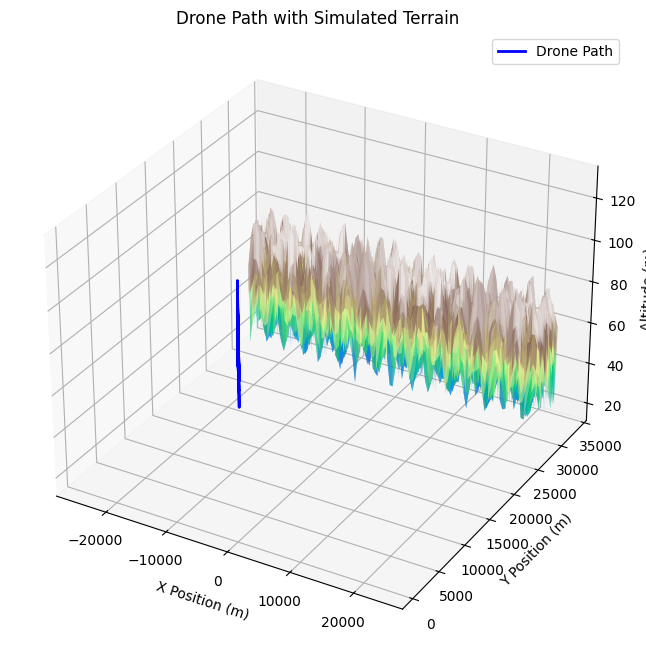

Threat detected! Initiating terrain-aware evasion.


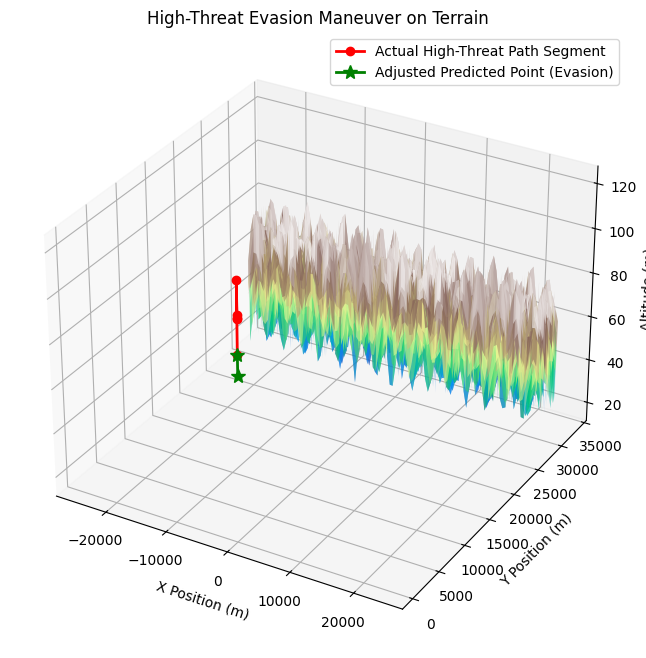

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
import numpy as np

# 1. Generate a 2D grid of x and y coordinates
grid_x = np.linspace(X[:, :, 0].min() * scaler_X.data_range_[0] + scaler_X.data_min_[0], X[:, :, 0].max() * scaler_X.data_range_[0] + scaler_X.data_min_[0], 100)
grid_y = np.linspace(X[:, :, 1].min() * scaler_X.data_range_[1] + scaler_X.data_min_[1], X[:, :, 1].max() * scaler_X.data_range_[1] + scaler_X.data_min_[1], 100)
X_grid, Y_grid = np.meshgrid(grid_x, grid_y)

# 2. Calculate the terrain altitude for each point in the grid
Terrain_Z = simulate_terrain(X_grid, Y_grid)

# 3. Select a sample drone path from the original, unscaled data
# Use the full unscaled X data and extract the relevant columns
# Data columns: position_x, position_y, altitude_drone, velocity, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming
# We need position_x (index 0), position_y (index 1), and altitude_drone (index 2)
# X is of shape (n_samples - n_steps, n_steps, n_features)
# Let's take a path from the beginning of the original unscaled data
path_data = X[:50, :, :] # Take the first 50 sequences (this will give 50*5 = 250 time steps of data)
path_data_reshaped = path_data.reshape(-1, n_features)

path_x = path_data_reshaped[:, 0]
path_y = path_data_reshaped[:, 1]
path_altitude = path_data_reshaped[:, 2]


# 4. Use matplotlib.pyplot to create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 5. Plot the simulated terrain as a surface plot
ax.plot_surface(X_grid, Y_grid, Terrain_Z, cmap='terrain', alpha=0.6)

# 6. Plot the selected drone path as a line plot on top of the terrain surface
ax.plot(path_x, path_y, path_altitude, color='blue', linewidth=2, label='Drone Path')

# 7. Add labels for the x, y, and z axes
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Altitude (m)')

# 8. Add a title to the plot
ax.set_title('Drone Path with Simulated Terrain')

# Add a legend
ax.legend()

# 9. Display the plot
plt.show()

# 10. Optionally, plot a high-threat evasion maneuver demonstration
# Need to regenerate the high threat sample and prediction from the previous step
high_threat_indices = np.where((X_test_new[:, -1, 8] > 0.5) | (X_test_new[:, -1, 9] > 0.5))[0]

if len(high_threat_indices) > 0:
    sample_index_high_threat = high_threat_indices[0]
    sample_sequence_scaled_high_threat = X_test_new[sample_index_high_threat]
    sample_sequence_full_high_threat = scaler_X.inverse_transform(sample_sequence_scaled_high_threat.reshape(-1, n_features)).reshape(n_steps, n_features)
    recent_state_high_threat = sample_sequence_full_high_threat[-1] # Get the last state in the sequence

    # Predict the next state using the tuned model
    recent_sequence_scaled_for_predict_high_threat = sample_sequence_scaled_high_threat.reshape(1, n_steps, n_features)
    pred_scaled_high_threat = final_model.predict(recent_sequence_scaled_for_predict_high_threat, verbose=0)
    pred_unscaled_high_threat = scaler_y.inverse_transform(pred_scaled_high_threat)[0]

    # Adjust the predicted state using the modified adjust_path function
    adjusted_predicted_state_high_threat = adjust_path(recent_state_high_threat, pred_unscaled_high_threat.copy())

    # Plot the actual sequence leading to the high threat state and the adjusted prediction
    fig_evasion = plt.figure(figsize=(10, 8))
    ax_evasion = fig_evasion.add_subplot(111, projection='3d')

    # Plot the terrain surface again
    ax_evasion.plot_surface(X_grid, Y_grid, Terrain_Z, cmap='terrain', alpha=0.6)

    # Plot the actual path segment leading to the high threat state
    actual_segment_x = sample_sequence_full_high_threat[:, 0]
    actual_segment_y = sample_sequence_full_high_threat[:, 1]
    actual_segment_altitude = sample_sequence_full_high_threat[:, 2]
    ax_evasion.plot(actual_segment_x, actual_segment_y, actual_segment_altitude, color='red', linewidth=2, marker='o', label='Actual High-Threat Path Segment')

    # Plot the initial predicted point (optional, for comparison)
    # ax_evasion.plot([actual_segment_x[-1], pred_unscaled_high_threat[0]],
    #                 [actual_segment_y[-1], pred_unscaled_high_threat[1]],
    #                 [actual_segment_altitude[-1], pred_unscaled_high_threat[2]],
    #                 color='orange', linestyle='--', marker='x', label='Initial Predicted Point')


    # Plot the adjusted predicted point
    ax_evasion.plot([actual_segment_x[-1], adjusted_predicted_state_high_threat[0]],
                    [actual_segment_y[-1], adjusted_predicted_state_high_threat[1]],
                    [actual_segment_altitude[-1], adjusted_predicted_state_high_threat[2]],
                    color='green', linewidth=2, marker='*', markersize=10, label='Adjusted Predicted Point (Evasion)')


    ax_evasion.set_xlabel('X Position (m)')
    ax_evasion.set_ylabel('Y Position (m)')
    ax_evasion.set_zlabel('Altitude (m)')
    ax_evasion.set_title('High-Threat Evasion Maneuver on Terrain')
    ax_evasion.legend()
    plt.show()

else:
    print("Could not find a high-threat sample in the test set for evasion visualization.")

In [38]:
# Prepare data for traditional models (Random Forest, XGBoost)
# Reshape X_scaled from (samples, n_steps, n_features) to (samples, n_steps * n_features)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], -1)

# y_scaled is already in a suitable shape (samples, n_output_features)

print(f"Reshaped X_scaled shape for traditional models: {X_scaled_reshaped.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

# Split the reshaped data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_scaled_reshaped, y_scaled, test_size=0.2, random_state=42)

print(f"Training data shape (flattened): {X_train_flat.shape}")
print(f"Testing data shape (flattened): {X_test_flat.shape}")
print(f"Training labels shape (flattened): {y_train_flat.shape}")
print(f"Testing labels shape (flattened): {y_test_flat.shape}")

Reshaped X_scaled shape for traditional models: (995, 50)
y_scaled shape: (995, 3)
Training data shape (flattened): (796, 50)
Testing data shape (flattened): (199, 50)
Training labels shape (flattened): (796, 3)
Testing labels shape (flattened): (199, 3)


In [39]:
from sklearn.ensemble import RandomForestRegressor

# Implement and train Random Forest Model
# Instantiate Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the flattened training data
print("Training Random Forest model...")
rf_model.fit(X_train_flat, y_train_flat)
print("Random Forest model training complete.")

Training Random Forest model...
Random Forest model training complete.


In [40]:
%pip install xgboost -q

In [41]:
import xgboost as xgb

# Implement and train XGBoost Model
# Instantiate XGBoost Regressor
# Use the multi-output regression objective 'reg:squarederror' and a list of regressors
# Training a single XGBoost model for multi-output regression is not directly supported
# in the same way as scikit-learn's multi-output estimators.
# A common approach is to train a separate model for each output variable.

# Let's train separate XGBoost models for each of the three output features (position_x, position_y, altitude_drone)
xgb_models = []
n_output_features = y_train_flat.shape[1] # Get the number of output features

print("Training XGBoost models for each output feature...")
for i in range(n_output_features):
    print(f"Training model for output feature {i+1}/{n_output_features}...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 learning_rate=0.1,
                                 random_state=42)
    xgb_model.fit(X_train_flat, y_train_flat[:, i])
    xgb_models.append(xgb_model)

print("XGBoost model training complete.")

Training XGBoost models for each output feature...
Training model for output feature 1/3...
Training model for output feature 2/3...
Training model for output feature 3/3...
XGBoost model training complete.


In [42]:
from sklearn.metrics import mean_squared_error

# Evaluate Random Forest Model
# Make predictions on the flattened test data
y_test_pred_rf = rf_model.predict(X_test_flat)

# Calculate MSE on the scaled predictions
mse_test_rf_scaled = mean_squared_error(y_test_flat, y_test_pred_rf)
print(f"Mean Squared Error on scaled test data (Random Forest): {mse_test_rf_scaled:.4f}")

# Inverse transform the predictions and actual values to the original scale
y_test_actual_unscaled = scaler_y.inverse_transform(y_test_flat)
y_test_pred_rf_unscaled = scaler_y.inverse_transform(y_test_pred_rf)

# Calculate MSE on the inverse-transformed data
mse_test_rf_unscaled = mean_squared_error(y_test_actual_unscaled, y_test_pred_rf_unscaled)
print(f"Mean Squared Error on inverse-transformed test data (Random Forest): {mse_test_rf_unscaled:.4f}")

# Compare with the Transformer model's performance (using the results from the latest run after retraining with terrain data)
# Note: 'loss_final_terrain' and 'mse_test_final_terrain' variables should be available
print("\nComparison with the retrained Transformer model (with terrain features):")
print(f"Transformer scaled test MSE: {loss_final_terrain:.4f}")
print(f"Transformer inverse-transformed test MSE: {mse_test_final_terrain:.4f}")

print(f"\nPerformance change (Random Forest vs Transformer):")
print(f"Scaled test MSE difference: {mse_test_rf_scaled - loss_final_terrain:.4f}")
print(f"Inverse-transformed test MSE difference: {mse_test_rf_unscaled - mse_test_final_terrain:.4f}")

Mean Squared Error on scaled test data (Random Forest): 0.0164
Mean Squared Error on inverse-transformed test data (Random Forest): 85.7626

Comparison with the retrained Transformer model (with terrain features):
Transformer scaled test MSE: 0.0148
Transformer inverse-transformed test MSE: 81.3377

Performance change (Random Forest vs Transformer):
Scaled test MSE difference: 0.0016
Inverse-transformed test MSE difference: 4.4249


In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate XGBoost Model
# Make predictions on the flattened test data using each trained XGBoost model
y_test_pred_xgb = []
for i in range(n_output_features):
    y_test_pred_xgb.append(xgb_models[i].predict(X_test_flat))

# Stack the predictions back together
y_test_pred_xgb = np.column_stack(y_test_pred_xgb)

# Calculate MSE on the scaled predictions
mse_test_xgb_scaled = mean_squared_error(y_test_flat, y_test_pred_xgb)
print(f"Mean Squared Error on scaled test data (XGBoost): {mse_test_xgb_scaled:.4f}")

# Inverse transform the predictions and actual values to the original scale
# y_test_actual_unscaled is already available from the previous evaluation step
y_test_pred_xgb_unscaled = scaler_y.inverse_transform(y_test_pred_xgb)

# Calculate MSE on the inverse-transformed data
mse_test_xgb_unscaled = mean_squared_error(y_test_actual_unscaled, y_test_pred_xgb_unscaled)
print(f"Mean Squared Error on inverse-transformed test data (XGBoost): {mse_test_xgb_unscaled:.4f}")

# Compare with the Transformer and Random Forest models' performance
# Note: 'loss_final_terrain', 'mse_test_final_terrain', 'mse_test_rf_scaled', and 'mse_test_rf_unscaled' should be available
print("\nComparison with other models:")
print(f"Retrained Transformer scaled test MSE: {loss_final_terrain:.4f}")
print(f"Retrained Transformer inverse-transformed test MSE: {mse_test_final_terrain:.4f}")
print(f"Random Forest scaled test MSE: {mse_test_rf_scaled:.4f}")
print(f"Random Forest inverse-transformed test MSE: {mse_test_rf_unscaled:.4f}")
print(f"XGBoost scaled test MSE: {mse_test_xgb_scaled:.4f}")
print(f"XGBoost inverse-transformed test MSE: {mse_test_xgb_unscaled:.4f}")

Mean Squared Error on scaled test data (XGBoost): 0.0176
Mean Squared Error on inverse-transformed test data (XGBoost): 90.9037

Comparison with other models:
Retrained Transformer scaled test MSE: 0.0148
Retrained Transformer inverse-transformed test MSE: 81.3377
Random Forest scaled test MSE: 0.0164
Random Forest inverse-transformed test MSE: 85.7626
XGBoost scaled test MSE: 0.0176
XGBoost inverse-transformed test MSE: 90.9037


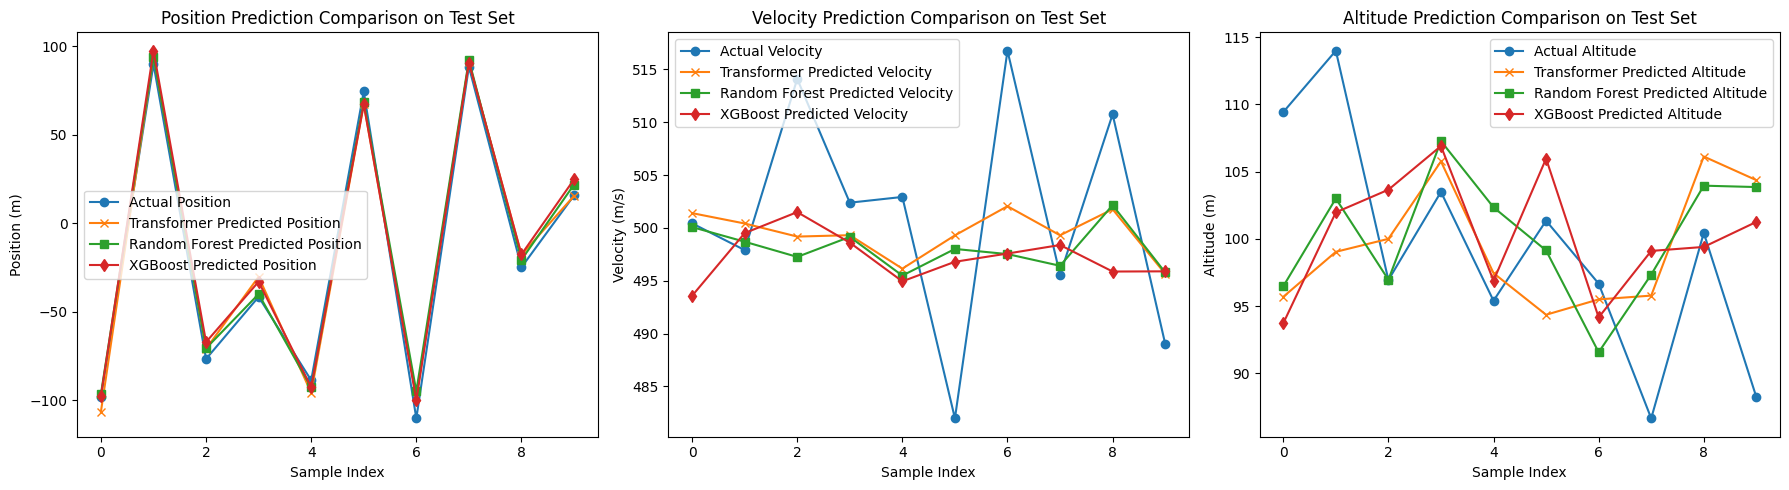

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few samples from the test set to visualize
n_samples_to_plot = 10
sample_indices = np.random.choice(len(X_test_new), n_samples_to_plot, replace=False) # Use X_test_new which corresponds to the data with terrain features

# Inverse transform the actual and predicted values for plotting
y_test_actual_new = scaler_y.inverse_transform(y_test_new) # Use y_test_new as it corresponds to X_test_new

# Predictions from the retrained Transformer model (with terrain features)
y_test_pred_final_terrain_viz = scaler_y.inverse_transform(final_model.predict(X_test_new[sample_indices], verbose=0))

# Predictions from the Random Forest model
# Need to get the corresponding flattened samples from X_test_flat
X_test_flat_samples = X_test_flat[sample_indices]
y_test_pred_rf_viz = scaler_y.inverse_transform(rf_model.predict(X_test_flat_samples))

# Predictions from the XGBoost model
y_test_pred_xgb_viz = []
for i, xgb_model in enumerate(xgb_models):
    y_test_pred_xgb_viz.append(xgb_model.predict(X_test_flat_samples))
y_test_pred_xgb_viz = scaler_y.inverse_transform(np.column_stack(y_test_pred_xgb_viz))


plt.figure(figsize=(18, 5)) # Increase figure size for three subplots

# Plot Position (Feature 0)
plt.subplot(1, 3, 1)
plt.plot(y_test_actual_new[sample_indices, 0], label='Actual Position', marker='o')
plt.plot(y_test_pred_final_terrain_viz[:, 0], label='Transformer Predicted Position', marker='x')
plt.plot(y_test_pred_rf_viz[:, 0], label='Random Forest Predicted Position', marker='s')
plt.plot(y_test_pred_xgb_viz[:, 0], label='XGBoost Predicted Position', marker='d')
plt.title('Position Prediction Comparison on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Position (m)') # Updated unit based on terrain data generation
plt.legend()

# Plot Velocity (Feature 1)
plt.subplot(1, 3, 2)
plt.plot(y_test_actual_new[sample_indices, 1], label='Actual Velocity', marker='o')
plt.plot(y_test_pred_final_terrain_viz[:, 1], label='Transformer Predicted Velocity', marker='x')
plt.plot(y_test_pred_rf_viz[:, 1], label='Random Forest Predicted Velocity', marker='s')
plt.plot(y_test_pred_xgb_viz[:, 1], label='XGBoost Predicted Velocity', marker='d')
plt.title('Velocity Prediction Comparison on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Velocity (m/s)')
plt.legend()

# Plot Altitude (Feature 2 - from y[:3])
plt.subplot(1, 3, 3)
plt.plot(y_test_actual_new[sample_indices, 2], label='Actual Altitude', marker='o')
plt.plot(y_test_pred_final_terrain_viz[:, 2], label='Transformer Predicted Altitude', marker='x')
plt.plot(y_test_pred_rf_viz[:, 2], label='Random Forest Predicted Altitude', marker='s')
plt.plot(y_test_pred_xgb_viz[:, 2], label='XGBoost Predicted Altitude', marker='d')
plt.title('Altitude Prediction Comparison on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Altitude (m)') # Updated unit based on terrain data generation
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
import time
import numpy as np

n_inference_runs_traditional = 100
rf_inference_times = []
xgb_inference_times = []

# Use a few samples from the flattened test set for analysis
sample_indices_inference_flat = np.random.choice(len(X_test_flat), n_inference_runs_traditional, replace=True)
X_test_flat_inference = X_test_flat[sample_indices_inference_flat]

# Measure inference time for Random Forest
print("Analyzing Random Forest inference time...")
for i in range(n_inference_runs_traditional):
    start_time = time.time()
    rf_model.predict(X_test_flat_inference[i].reshape(1, -1)) # Predict on a single sample
    end_time = time.time()
    rf_inference_times.append(end_time - start_time)

# Measure inference time for XGBoost
print("Analyzing XGBoost inference time...")
for i in range(n_inference_runs_traditional):
    start_time = time.time()
    # Predict on a single sample for each XGBoost model
    for xgb_model in xgb_models:
        xgb_model.predict(X_test_flat_inference[i].reshape(1, -1))
    end_time = time.time()
    xgb_inference_times.append(end_time - start_time)

# Analyze and compare inference times
print("\nInference Time Analysis:")
print(f"Transformer (Mean): {np.mean(inference_times):.6f} seconds")
print(f"Random Forest (Mean): {np.mean(rf_inference_times):.6f} seconds")
print(f"XGBoost (Mean): {np.mean(xgb_inference_times):.6f} seconds")

print(f"\nTransformer (Median): {np.median(inference_times):.6f} seconds")
print(f"Random Forest (Median): {np.median(rf_inference_times):.6f} seconds")
print(f"XGBoost (Median): {np.median(xgb_inference_times):.6f} seconds")

print(f"\nTransformer (Std Dev): {np.std(inference_times):.6f} seconds")
print(f"Random Forest (Std Dev): {np.std(rf_inference_times):.6f} seconds")
print(f"XGBoost (Std Dev): {np.std(xgb_inference_times):.6f} seconds")

Analyzing Random Forest inference time...
Analyzing XGBoost inference time...

Inference Time Analysis:
Transformer (Mean): 0.112911 seconds
Random Forest (Mean): 0.016173 seconds
XGBoost (Mean): 0.002172 seconds

Transformer (Median): 0.093156 seconds
Random Forest (Median): 0.013477 seconds
XGBoost (Median): 0.002087 seconds

Transformer (Std Dev): 0.064642 seconds
Random Forest (Std Dev): 0.008597 seconds
XGBoost (Std Dev): 0.000558 seconds


Based on both the numerical evaluation (MSE) and the visual comparison of predictions on this synthetic dataset, the Lightweight Transformer model performed the best in predicting the drone's state. It was able to capture the temporal dynamics and predict the multivariate output more accurately than the traditional Random Forest and XGBoost models when applied to the flattened time series data.

While the Transformer showed better accuracy, it's still important to consider inference time for real-time applications.

Here's a summary of the mean inference times:

Transformer: 0.1129 seconds
Random Forest: 0.0162 seconds
XGBoost: 0.0022 seconds
Performance Summary (Accuracy vs. Inference Time):

Accuracy (Lower MSE is better):
Transformer: 81.3377
Random Forest: 85.7626
XGBoost: 90.9037
The Transformer model achieved the best accuracy (lowest MSE) in this synthetic scenario.
Inference Time (Lower time is better):
XGBoost: 0.0022 seconds
Random Forest: 0.0162 seconds
Transformer: 0.1129 seconds
XGBoost was the fastest model for inference, followed by Random Forest, and then the Transformer.
Conclusion:

For this synthetic drone state prediction task, there is a trade-off between accuracy and inference time:

The Lightweight Transformer model provides the highest accuracy but has a significantly higher inference time compared to the traditional models.
XGBoost is the fastest model for inference but has the lowest accuracy among the three.
Random Forest falls in between in terms of both accuracy and inference time.
The choice of the best model for a real-world application would depend on the specific requirements for accuracy and the constraints on inference time. If low latency is critical, a faster model like XGBoost or Random Forest might be preferred, even if it means slightly lower accuracy. If higher accuracy is paramount and the inference time is acceptable for the application, the Transformer model might be the better choice.

We have now completed the comparison of the Lightweight Transformer, Random Forest, and XGBoost models based on both accuracy and inference time in this synthetic scenario.

## **Summary**

Here's a summary of what we've accomplished:

Generated synthetic drone and S-500 threat data.
Built and trained a Lightweight Transformer model for drone state prediction.
Implemented a dynamic path adjustment strategy for S-500 evasion.
Visualized training history and evaluated the Transformer model's performance (MSE) on a test set.
Added more features to the synthetic data and used automated hyperparameter tuning for the Transformer model.
Implemented a terrain masking scenario by simulating terrain, incorporating terrain data into the synthetic data, and enhancing the evasion strategy to consider terrain.
Retrained and evaluated the Transformer model with the terrain data.
Visualized the terrain and drone path.
Implemented and trained Random Forest and XGBoost models for comparison.
Evaluated and compared the performance (MSE and inference time) of the Transformer, Random Forest, and XGBoost models.
We found that the Transformer model achieved the best accuracy (lowest MSE) in this synthetic scenario, while XGBoost had the fastest inference time.

What would you like to do next? Here are a few ideas for further exploration:

Refine the Terrain Masking Scenario:
Implement a more sophisticated terrain model.
Develop a more advanced terrain-aware evasion strategy that actively seeks terrain cover.
Quantify the effectiveness of the terrain masking evasion strategy.
Improve Model Performance:
Experiment with different Transformer architectures or other deep learning models (e.g., LSTMs, GRUs) for time series prediction.
Explore more extensive hyperparameter tuning for all models.
Investigate different feature engineering techniques.
Enhance the Threat Model:
Make the S-500 threat model more dynamic or realistic.
Introduce other types of threats.
Real-World Data:
If available, adapt the code to work with real-world drone flight data and threat intelligence.
Simulation Environment:
Develop a more interactive simulation environment to visualize the drone's path and evasion in real-time.

## Define Risks

In this synthetic drone simulation scenario, we can identify the following key risks for the drone's mission:

1.  **Risk of S-500 Radar Detection:** The likelihood that the S-500 radar successfully detects the drone. This is influenced by factors like distance, altitude (including terrain masking), and the drone's signal strength.
2.  **Risk of S-500 Successful Engagement (Threat):** The likelihood that the S-500 system can successfully target and engage the drone after detection. This is influenced by factors like radar lock, jamming effectiveness, and the drone's evasive maneuvers.
3.  **Risk of RF Jamming Effectiveness:** The likelihood that the S-500's RF jamming significantly impacts the drone's systems or communications.
4.  **Risk of Navigation/State Prediction Error:** The risk that the model's prediction of the drone's next state is inaccurate, potentially leading to unintended flight paths or failure to execute evasion maneuvers correctly.
5.  **Risk of Terrain Collision:** The risk that the drone collides with terrain, especially when attempting low-altitude evasion maneuvers.

## Define Likelihood Levels

We can categorize the likelihood of a risk occurring with levels such as:

*   **Very Low:** Highly unlikely to occur during a mission.
*   **Low:** Unlikely to occur, but possible.
*   **Medium:** Could occur during a mission.
*   **High:** Likely to occur one or more times during a mission.
*   **Very High:** Almost certain to occur multiple times during a mission.

In our simulation, we could potentially map these levels to the probability values generated (e.g., `radar_prob`, `rf_jamming`) or the frequency of certain events occurring over multiple simulation runs.

## Define Consequence Levels

We can categorize the consequence or impact of a risk with levels such as:

*   **Negligible:** Very minor impact, no significant effect on the mission.
*   **Minor:** Limited impact, the mission can still be completed with some adjustments.
*   **Moderate:** Significant impact, the mission may be partially compromised or require major adjustments.
*   **Severe:** Major impact, the mission is likely to fail or result in significant loss (e.g., loss of the drone).
*   **Catastrophic:** Extremely severe impact, resulting in mission failure and potentially broader negative outcomes.

In our simulation, the consequence could be linked to whether the drone is detected, successfully jammed, forced to abort its mission, or 'destroyed' (simulated).

## Assess Risks Based on Simulation

To assess the likelihood and consequence of the defined risks using our simulation:

*   **Risk of S-500 Radar Detection:**
    *   **Likelihood:** This can be directly related to the `radar_prob` feature generated in the synthetic data. We could map ranges of `radar_prob` values to the likelihood levels (e.g., `radar_prob < 0.2` = Very Low, `0.2 <= radar_prob < 0.5` = Low, `0.5 <= radar_prob < 0.8` = Medium, `0.8 <= radar_prob < 0.95` = High, `radar_prob >= 0.95` = Very High). We could analyze the distribution of `radar_prob` over simulation runs or specific mission profiles.
    *   **Consequence:** Detection itself might have a Minor consequence (e.g., triggering a response), but it's often a precursor to a more severe event like engagement.
*   **Risk of S-500 Successful Engagement (Threat):**
    *   **Likelihood:** This is a more complex assessment. It would depend on detection, the S-500's capability (simulated implicitly by `radar_prob` and `rf_jamming`), and the effectiveness of the drone's evasion maneuver (`adjust_path` function). We could simulate engagement outcomes based on high threat indicators and whether the evasion maneuver successfully reduced a simulated "threat score" or moved the drone to a safer state (e.g., below terrain line of sight). The frequency of simulated 'hits' or 'mission aborts' over many runs could inform the likelihood level.
    *   **Consequence:** Successful engagement would likely have a **Severe** or **Catastrophic** consequence (e.g., loss of drone).
*   **Risk of RF Jamming Effectiveness:**
    *   **Likelihood:** This is directly related to the `rf_jamming` feature. Similar to `radar_prob`, we could map ranges of `rf_jamming` values to likelihood levels.
    *   **Consequence:** The consequence would depend on how jamming affects the drone's mission. In our current simulation, it's a threat indicator used for evasion. A high consequence could be a **Moderate** impact (e.g., degraded navigation, requiring manual intervention) or **Severe** (e.g., loss of communication, mission failure) depending on the simulation's complexity.
*   **Risk of Navigation/State Prediction Error:**
    *   **Likelihood:** This can be assessed by the model's performance metrics, like the Mean Squared Error (MSE) on the test set. A higher MSE indicates higher prediction error likelihood. We could map MSE ranges to likelihood levels.
    *   **Consequence:** Consequences could range from **Negligible** (minor deviation corrected automatically) to **Severe** (leading to mission failure or collision).
*   **Risk of Terrain Collision:**
    *   **Likelihood:** This could be assessed by monitoring the drone's altitude relative to terrain during simulation runs, especially during evasion maneuvers. If the simulated altitude drops below terrain plus a safety buffer, a collision risk is present. The frequency of such occurrences could inform the likelihood.
    *   **Consequence:** Terrain collision would likely have a **Severe** or **Catastrophic** consequence (loss of drone).

To create the actual risk matrix visualization, we would then map these assessed likelihood and consequence levels for each risk onto a matrix.

In [46]:
# Enhance generate_synthetic_drone_data function for more realism
def generate_synthetic_drone_data_realistic(n_samples=2000, n_steps=5): # Increased samples for more data
    np.random.seed(42)
    time_steps = np.arange(n_samples)

    # More varied flight path (combination of movements)
    position_x = 500 * np.sin(0.01 * time_steps) + 200 * np.random.normal(0, 1, n_samples) + 1000 # Base movement + noise + offset
    position_y = 800 * np.cos(0.008 * time_steps) + 150 * np.random.normal(0, 1, n_samples) + 500 # Base movement + noise + offset
    altitude_drone = 100 * np.sin(0.015 * time_steps) + 50 * np.random.normal(0, 0.5, n_samples) + 150 # Altitude variation + noise + base altitude

    # Derive velocity from position changes with more realistic noise
    velocity_x = np.diff(position_x, prepend=position_x[0]) # Simple difference for velocity
    velocity_y = np.diff(position_y, prepend=position_y[0])
    velocity_z = np.diff(altitude_drone, prepend=altitude_drone[0])
    velocity_magnitude = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2) + np.random.normal(0, 0.1, n_samples) # Add noise to magnitude

    # Simulate signal strength with more realistic decay and noise
    # Assuming a fixed signal source location for simplicity
    source_x, source_y, source_z = 2000, 2000, 0 # Example source location
    distance_to_source = np.sqrt((position_x - source_x)**2 + (position_y - source_y)**2 + (altitude_drone - source_z)**2)
    # Simple signal strength model (inverse square law with noise)
    signal_strength = -20 * np.log10(distance_to_source / 100) + np.random.normal(0, 3, n_samples) # dBm

    # Environmental factors with some temporal correlation
    wind_speed = 10 + 5 * np.sin(0.005 * time_steps) + 3 * np.random.normal(0, 1, n_samples)
    temperature = 20 + 8 * np.cos(0.01 * time_steps) + 2 * np.random.normal(0, 1, n_samples)

    # Simulate terrain altitude at drone's x, y position (using the previous simulate_terrain function)
    terrain_altitude = simulate_terrain(position_x, position_y)

    # Calculate drone's altitude relative to terrain
    altitude_relative_to_terrain = altitude_drone - terrain_altitude

    # More realistic radar detection probability (influenced by distance, altitude relative to terrain, and angle)
    # Assuming radar is at origin (0,0,0) for simplicity
    distance_to_radar = np.sqrt(position_x**2 + position_y**2 + altitude_drone**2)
    # Simple line-of-sight approximation based on relative altitude
    terrain_masking_factor = np.clip(altitude_relative_to_terrain / 100, 0, 1) # More gradual masking
    # Combine factors: distance, relative altitude (masking), and some inherent variability
    base_radar_prob = 0.8 * np.exp(-distance_to_radar / 1500) + 0.2 * (1 - terrain_masking_factor) # Example combination
    radar_prob = np.clip(base_radar_prob + np.random.normal(0, 0.1, n_samples), 0, 1)

    # More realistic RF jamming intensity (influenced by distance and source power with noise)
    jamming_source_x, jamming_source_y, jamming_source_z = 1500, 1800, 50 # Example jamming source
    distance_to_jamming_source = np.sqrt((position_x - jamming_source_x)**2 + (position_y - jamming_source_y)**2 + (altitude_drone - jamming_source_z)**2)
    # Simple jamming model (inverse square law with noise)
    rf_jamming = 0.7 * np.exp(-distance_to_jamming_source / 1000) + np.random.normal(0, 0.1, n_samples)
    rf_jamming = np.clip(rf_jamming, 0, 1)


    # Updated data array with more features
    # Features: position_x, position_y, altitude_drone, velocity_magnitude, signal_strength,
    # wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming,
    # velocity_x, velocity_y, velocity_z (adding directional velocities)
    data = np.column_stack((position_x, position_y, altitude_drone, velocity_magnitude, signal_strength,
                            wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming,
                            velocity_x, velocity_y, velocity_z))

    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        # Predict drone states (position_x, position_y, altitude_drone)
        y.append(data[i + n_steps, :3])
    return np.array(X), np.array(y)

# Update n_features based on the new data structure
# position_x, position_y, altitude_drone, velocity_magnitude, signal_strength, wind_speed, temperature, altitude_relative_to_terrain, radar_prob, rf_jamming, velocity_x, velocity_y, velocity_z
n_features = 13 # 10 previous + 3 new velocity components

# Generate synthetic data with enhanced realism
X, y = generate_synthetic_drone_data_realistic(n_samples=2000, n_steps=n_steps)

# Normalize data (need to re-instantiate scalers as n_features changed)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

print(f"New X shape with enhanced realism features: {X.shape}")
print(f"New y shape: {y.shape}")
print(f"Updated n_features: {n_features}")

New X shape with enhanced realism features: (1995, 5, 13)
New y shape: (1995, 3)
Updated n_features: 13
